In [1]:
#python3 -m pip install tld

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from colorama import Fore
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from tld import get_tld, is_tld
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

In [3]:
data = pd.read_csv('malicious_phish.csv')
data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [4]:
data['url'] = data['url'].replace('www.', '', regex=True)
data

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://garage-pirenne.be/index.php?option=com_...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
651188,gamespot.com/xbox360/action/deadspace/,phishing
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing


In [5]:
rem = {"Category": {"benign": 0, "defacement": 1, "phishing":2, "malware":3}}
data['Category'] = data['type']
data = data.replace(rem)

In [6]:
data['url_len'] = data['url'].apply(lambda x: len(str(x)))

In [7]:
def process_tld(url):
    try:
        res = get_tld(url, as_object = True, fail_silently=False,fix_protocol=True)
        pri_domain= res.parsed_url.netloc
    except :
        pri_domain= None
    return pri_domain

In [8]:
data['domain'] = data['url'].apply(lambda i: process_tld(i))

In [9]:
feature = ['@','?','-','=','.','#','%','+','$','!','*',',','//']
for a in feature:
    data[a] = data['url'].apply(lambda i: i.count(a))

In [10]:
def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

In [11]:
data['abnormal_url'] = data['url'].apply(lambda i: abnormal_url(i))

In [12]:
def httpSecure(url):
    htp = urlparse(url).scheme
    match = str(htp)
    if match=='https':
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

In [13]:
data['https'] = data['url'].apply(lambda i: httpSecure(i))

In [14]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits

In [15]:
data['digits']= data['url'].apply(lambda i: digit_count(i))

In [16]:
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

In [17]:
data['letters']= data['url'].apply(lambda i: letter_count(i))

In [18]:
def Shortining_Service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0

In [19]:
data['Shortining_Service'] = data['url'].apply(lambda x: Shortining_Service(x))

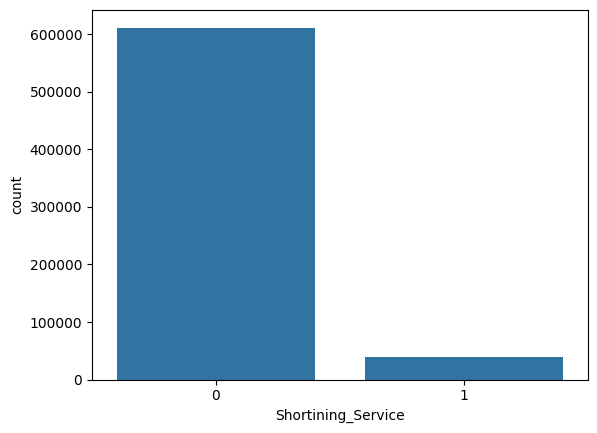

In [20]:
sns.countplot(x='Shortining_Service', data=data);

In [21]:
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4 with port
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
        '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
        '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)  # Ipv6
    if match:
        return 1
    else:
        return 0

In [22]:
data['having_ip_address'] = data['url'].apply(lambda i: having_ip_address(i))

In [29]:
data.to_csv('data_feature_engineered.csv')

In [23]:
X = data.drop(['url','type','Category','domain'],axis=1)#,'type_code'
y = data['Category']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [30]:
models = [RandomForestClassifier]

In [32]:
accuracy_test = []

In [34]:
MyRandomForest = RandomForestClassifier()
MyRandomForest.fit(X_train, y_train)
pred = MyRandomForest.predict(X_test)
acc = accuracy_score(pred, y_test)
accuracy_test.append(acc)
print('Test Accuracy :\033[32m \033[01m {:.2f}% \033[30m \033[0m'.format(acc*100))

Test Accuracy :  91.48%  


In [35]:
import pickle

In [36]:
# pour exporter le modèle

with open('RandomForest.pkl','wb') as f:
    pickle.dump(MyRandomForest,f)

In [37]:
# pour charger le modèle
#import pickle
#from sklearn.ensemble import RandomForestClassifier

#with open('RandomForest.pkl', 'rb') as f:
#    TrainedRandomForest = pickle.load(f)

#PreTrainedRandomForest.predict(X[0:1])

# CUSTOM

In [48]:
data = pd.read_csv('data_feature_engineered.csv', index_col=0)

In [60]:
data

,url,type,Category,url_len,domain,@,?,-,=,.,...,!,*,",",//,abnormal_url,https,digits,letters,Shortining_Service,having_ip_address
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,...,0,0,0,0,0,0,0,13,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,...,0,0,0,0,0,0,1,29,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,...,0,0,0,0,0,0,1,25,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,...,0,0,0,1,1,0,7,60,0,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,...,0,0,0,1,1,0,22,199,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,2,39,xbox360.ign.com,0,0,0,0,3,...,0,0,0,0,0,0,12,21,0,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,2,44,games.teamxbox.com,0,0,2,0,2,...,0,0,0,0,0,0,7,29,1,0
651188,gamespot.com/xbox360/action/deadspace/,phishing,2,38,gamespot.com,0,0,0,0,1,...,0,0,0,0,0,0,3,30,1,0
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,2,45,en.wikipedia.org,0,0,0,0,2,...,0,0,0,0,0,0,0,36,0,0


In [49]:
data.head()

,url,type,Category,url_len,domain,@,?,-,=,.,...,!,*,",",//,abnormal_url,https,digits,letters,Shortining_Service,having_ip_address
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,...,0,0,0,0,0,0,0,13,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,...,0,0,0,0,0,0,1,29,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,...,0,0,0,0,0,0,1,25,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,...,0,0,0,1,1,0,7,60,0,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,...,0,0,0,1,1,0,22,199,0,0


In [50]:
X = data.drop(['url','type','Category','domain'],axis=1)
y = data['Category']

In [51]:
# Encoder la classe
y_binary = y.apply(lambda x: 0 if x == 'benign' else 1)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.3, random_state=2)

In [62]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [54]:
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid')) 

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [56]:
model.fit(X_train, y_train, epochs=10, batch_size=256, validation_data=(X_test, y_test))

Epoch 1/10
2035/2035 [==============================] - 13s 6ms/step - loss: 0.0066 - accuracy: 0.9996 - val_loss: 1.2241e-05 - val_accuracy: 1.0000
Epoch 2/10
2035/2035 [==============================] - 10s 5ms/step - loss: 5.3573e-06 - accuracy: 1.0000 - val_loss: 2.0734e-06 - val_accuracy: 1.0000
Epoch 3/10
2035/2035 [==============================] - 11s 5ms/step - loss: 1.1139e-06 - accuracy: 1.0000 - val_loss: 5.3786e-07 - val_accuracy: 1.0000
Epoch 4/10
2035/2035 [==============================] - 9s 5ms/step - loss: 3.0803e-07 - accuracy: 1.0000 - val_loss: 1.5990e-07 - val_accuracy: 1.0000
Epoch 5/10
2035/2035 [==============================] - 11s 5ms/step - loss: 9.4580e-08 - accuracy: 1.0000 - val_loss: 5.1693e-08 - val_accuracy: 1.0000
Epoch 6/10
2035/2035 [==============================] - 11s 5ms/step - loss: 3.1898e-08 - accuracy: 1.0000 - val_loss: 1.8809e-08 - val_accuracy: 1.0000
Epoch 7/10
2035/2035 [==============================] - 12s 6ms/step - loss: 1.2655e-08

In [57]:
y_pred = model.predict(X_test)
y_pred_class = (y_pred > 0.5).astype(int)
acc = accuracy_score(y_test, y_pred_class)
print('Test Accuracy :\033[32m \033[01m {:.2f}% \033[30m \033[0m'.format(acc*100))

4070/4070 [==============================] - 13s 3ms/step
Test Accuracy :  100.00%  


In [59]:
model.save('DNN_classifier.keras')